In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import stheno.torch as stheno

#import convcnp.data
from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, init_sequential_weights, to_multiple
from convcnp.architectures import SimpleConv, UNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
figsiz_=(11,2.5*2)
fontsiz = 18


plt.rc('figure', figsize=figsiz_,dpi=100)
plt.rcParams['figure.figsize'] = figsiz_
plt.rc('font', family='serif', size=fontsiz)

In [4]:
import random
random_seed = 1111
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [5]:
import mogptk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



## preparation dataset: bramblemet
### checked working but exploration quite not fitted well

In [6]:
from collections import OrderedDict

start_date = '2020-06-02'
#end_date = '2020-06-07' #work doen checked
end_date = '2020-06-08'

print('Loading Bramble')
bramblemet = pd.read_csv('data/bramblemet/bramblemet.csv.gz', compression='gzip', low_memory=False)
bramblemet['Date'] = pd.to_datetime(bramblemet['Date'] + ' ' + bramblemet['Time'], format='%d/%m/%Y %H:%M')
bramblemet = bramblemet.drop(columns=['Time'])
bramblemet = bramblemet.loc[(bramblemet['Date'] >= start_date) & (bramblemet['Date'] < end_date)]

print('Loading Camber')
cambermet = pd.read_csv('data/bramblemet/cambermet.csv.gz', compression='gzip', low_memory=False)
cambermet['Date'] = pd.to_datetime(cambermet['Date'] + ' ' + cambermet['Time'], format='%d/%m/%Y %H:%M')
cambermet = cambermet.drop(columns=['Time'])
cambermet = cambermet.loc[(cambermet['Date'] >= start_date) & (cambermet['Date'] < end_date)]

print('Loading Chi')
chimet = pd.read_csv('data/bramblemet/chimet.csv.gz', compression='gzip', low_memory=False)
chimet['Date'] = pd.to_datetime(chimet['Date'] + ' ' + chimet['Time'], format='%d/%m/%Y %H:%M')
chimet = chimet.drop(columns=['Time'])
chimet = chimet.loc[(chimet['Date'] >= start_date) & (chimet['Date'] < end_date)]

print('Loading Soton')
sotonmet = pd.read_csv('data/bramblemet/sotonmet.csv.gz', compression='gzip', low_memory=False)
sotonmet['Date'] = pd.to_datetime(sotonmet['Date'] + ' ' + sotonmet['Time'], format='%d/%m/%Y %H:%M')
sotonmet = sotonmet.drop(columns=['Time'])
sotonmet = sotonmet.loc[(sotonmet['Date'] >= start_date) & (sotonmet['Date'] < end_date)]



normalize=True
dataset_dict = OrderedDict()
# dataset_dict['bramblemet'] = bramblemet
# dataset_dict['cambermet'] = cambermet
# dataset_dict['chimet'] = chimet
# dataset_dict['sotonmet'] = sotonmet
dataset_dict[0] = bramblemet
dataset_dict[1] = cambermet
dataset_dict[2] = chimet
dataset_dict[3] = sotonmet

num_channels = 4
default_round = 100000000000

time_scale = 60*24 #5minute per obesration
for ith_dict in dataset_dict:
    x = dataset_dict[ith_dict]['Date'].to_numpy().astype('int')/default_round
    y = dataset_dict[ith_dict]['DEPTH'].to_numpy(dtype=np.float32)    
    #dataset_dict[ith_dict] = 
    x,y = np.asarray(x,dtype=np.float32),np.asarray(y,dtype=np.float32)
    dataset_dict[ith_dict] = {}
    dataset_dict[ith_dict]['x'] = x
    dataset_dict[ith_dict]['y'] = y
    
    
    if normalize == True:
        dataset_dict[ith_dict]['x'] -= dataset_dict[ith_dict]['x'][0]
        dataset_dict[ith_dict]['x'] /= time_scale
        dataset_dict[ith_dict]['y'] = (dataset_dict[ith_dict]['y'] - dataset_dict[ith_dict]['y'].mean())/dataset_dict[ith_dict]['y'].std()

        
        
        
        
print('')
for ith_key in dataset_dict:
    print(ith_key,len(dataset_dict[ith_key]['x']))



Loading Bramble
Loading Camber
Loading Chi
Loading Soton

0 1236
1 1728
2 1726
3 1711


In [7]:
def get_index(dataset_dict,test_type = 'inter',test_len=24):
    
    time_dict_index = {}    
    if test_type == 'inter':
        for ith_channel in dataset_dict:
            #print(dataset_dict[ith_channel]['x'])
            full_len = len(dataset_dict[ith_channel]['x'])
            
            start_index = np.random.choice(full_len-test_len,1)[0]

            full_idx = np.arange(full_len)
            target_idx = np.arange(start_index,start_index+test_len)
            context_idx = np.setdiff1d(full_idx,target_idx)
            time_dict_index[ith_channel] = {'context_idx':context_idx,'target_idx':target_idx}
    
    elif test_type == 'extra':
        for ith_channel in dataset_dict:  
            full_len = len(dataset_dict[ith_channel]['x'])            
            full_idx = np.arange(full_len)
            target_idx = full_idx[-test_len:]
            context_idx = full_idx[:-test_len]
            #print(full_index)
            #print(target_idx,context_idx)
            #print('')
            time_dict_index[ith_channel] = {'context_idx':context_idx,'target_idx':target_idx}        
    else:
        pass
    
    return time_dict_index
    
    
#

In [8]:
#dataset_dict

#def prepare_batch(dataset_dict, time_dict_index

def nparray2tensor(context_x,context_y,target_x,target_y):
    return torch.tensor(context_x).float(),\
           torch.tensor(context_y).float(),\
           torch.tensor(target_x).float(),\
           torch.tensor(target_y).float()


def prepare_batch(dataset_dict, time_dict_index , nbatch = 32,batch_npoints=(64,64), intrain = True):
    context_x,context_y = [],[]
    target_x,target_y = [],[]
    full_x,full_y = [],[]
    
    #n_points = len(x)
    #time_dict_index = get_index(dataset_dict,test_option = test_option,test_len=test_len)
    
    for _ in range(nbatch):

        i_context_x,i_context_y = [],[]
        i_target_x,i_target_y = [],[]
        i_full_x,i_full_y = [],[]
        for ith_channel in time_dict_index:
            if intrain :
                sampled_c_idx = np.random.choice(time_dict_index[ith_channel]['context_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['context_idx'])))
                sampled_t_idx = np.random.choice(time_dict_index[ith_channel]['context_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['context_idx'])))
                sampled_c_idx.sort() 
                sampled_t_idx.sort() 
                ith_context_x,ith_context_y = dataset_dict[ith_channel]['x'][sampled_c_idx],dataset_dict[ith_channel]['y'][sampled_c_idx]
                ith_target_x,ith_target_y = dataset_dict[ith_channel]['x'][sampled_t_idx],dataset_dict[ith_channel]['y'][sampled_t_idx]        
                
                
                

            else:                
                sampled_c_idx = np.random.choice(time_dict_index[ith_channel]['context_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['context_idx'])))
                sampled_t_idx = np.random.choice(time_dict_index[ith_channel]['target_idx'],min(batch_npoints[0],len(time_dict_index[ith_channel]['target_idx'])))
                #print('sampled_t_idx ')
                #print(sampled_t_idx )
                sampled_c_idx.sort() 
                sampled_t_idx.sort() 
                ith_context_x,ith_context_y = dataset_dict[ith_channel]['x'][sampled_c_idx],dataset_dict[ith_channel]['y'][sampled_c_idx]
                
                #print('ith_context_x,ith_context_y')
                #print(ith_context_x,ith_context_y)
                
                
                ith_target_x,ith_target_y = dataset_dict[ith_channel]['x'][sampled_t_idx],dataset_dict[ith_channel]['y'][sampled_t_idx]        

                #print('ith_target_x,ith_target_y ')
                #print(ith_target_x,ith_target_y )

            i_context_x.append(ith_context_x)
            i_context_y.append(ith_context_y) 
            i_target_x.append(ith_target_x)
            i_target_y.append(ith_target_y) 
            i_full_x.append(dataset_dict[ith_channel]['x'])
            i_full_y.append(dataset_dict[ith_channel]['y']) 



        i_context_x,i_context_y = np.asarray(i_context_x).T,np.asarray(i_context_y).T
        i_target_x,i_target_y = np.asarray(i_target_x).T,np.asarray(i_target_y).T   
        i_full_x,i_full_y = np.asarray(i_full_x).T,np.asarray(i_full_y).T   

        #print(i_full_x.shape)
        
        #print(i_context_x.shape,i_context_y.shape,i_target_x.shape,i_target_y.shape)
        
        context_x.append( i_context_x )
        context_y.append( i_context_y )
        target_x.append( i_target_x  )
        target_y.append( i_target_y )
        #full_x.append(i_full_x)
        #full_y.append(i_full_y)
    
    #print(type(context_x))        

    context_x = np.asarray(context_x,dtype=np.float32)
    context_y = np.asarray(context_y,dtype=np.float32)
    target_x = np.asarray(target_x,dtype=np.float32)
    target_y = np.asarray(target_y,dtype=np.float32)
    #full_x = np.asarray(full_x,dtype=np.float32)
    #full_y = np.asarray(full_y,dtype=np.float32)
    
    #context_x = torch.tensor(context_x).float()
    #context_y = torch.tensor(context_y).float()
    #target_x = torch.tensor(target_x).float()
    #target_y = torch.tensor(target_y).float()
    
    #return context_x,context_y,target_x,target_y,full_x,full_y
    
    context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)
    return context_x,context_y,target_x,target_y


In [9]:
#---------------------------------------------
# reparation dataset: bramblemet "large datset"
#---------------------------------------------
#time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=128)

#time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=128)
time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=256)


/home/yohan/Myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


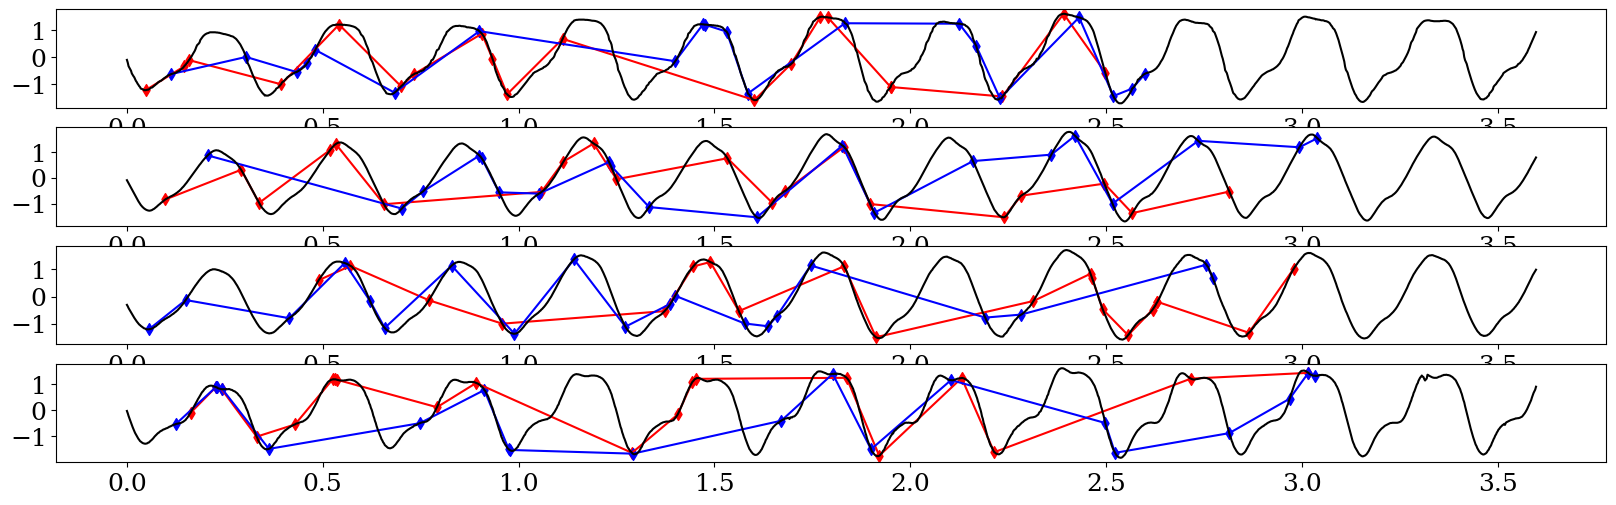

/home/yohan/Myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


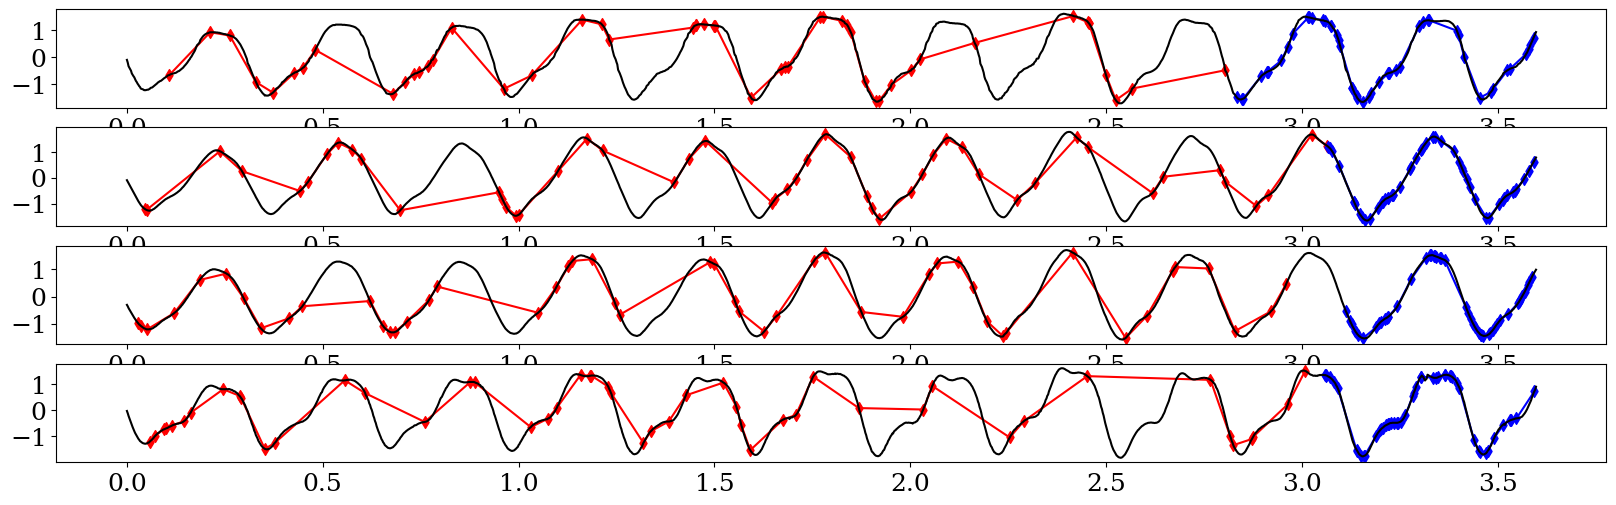

In [10]:

ncontext,ntarget=20,100
context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(ncontext,ntarget), intrain = True)


plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d')
    plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d')
    plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k')
    
plt.show()
print('\n'*5)



ncontext,ntarget=20,100    
context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 3,batch_npoints=(50,50), intrain = False)
plt.figure(figsize=(20,1.5*num_channels))
for ith in range(num_channels):
    plt.subplot(num_channels,1,ith+1)
    plt.scatter(context_x[2][:,ith],context_y[2][:,ith],color='r',marker='d')
    plt.plot(context_x[2][:,ith],context_y[2][:,ith],'r')
    
    plt.scatter(target_x[2][:,ith],target_y[2][:,ith],color='b',marker='d')
    plt.plot(target_x[2][:,ith],target_y[2][:,ith],'b')    
    
    plt.plot(dataset_dict[ith]['x'],dataset_dict[ith]['y'],'k')
plt.show()


## used num dataset

In [11]:
len(dataset_dict[0]['x']),len(dataset_dict[1]['x']),len(dataset_dict[2]['x']),len(dataset_dict[3]['x'])

(1236, 1728, 1726, 1711)

In [12]:
# from test_baseline import Convcnp,compute_loss_baseline
# from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
# #from test_correlatenp import  CGP_Convnp,compute_loss_gp        
# from test_mocorrelatenp import  CGP_Convnp,compute_loss_gp        

from test_baseline import Convcnp,compute_loss_baseline
from test_baseline_latent import  Convcnp_latent, compute_loss_baselinelatent
from test_dep_correlatenp import  DCGP_Convnp,compute_loss_gp  
from test_ind_correlatenp import  ICGP_Convnp,compute_loss_gp  



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def to_numpy(x):
    """Convert a PyTorch tensor to NumPy."""
    return x.squeeze().detach().cpu().numpy()




num_channels = 4
nsamples_latent=10
#nsamples_gp = 10
nsamples_gp = 5



lr = 0.001
weight_decay=1e-4
#cnntype = 


init_lengthscale = 0.1
#init_lengthscale = 0.05
#def get_model(modelname='gp'):        
def get_model(modelname='gpdep',cnntype='deep'):        
    
    if modelname == 'base':
        model = Convcnp(in_dims=1,out_dims=1,num_channels=num_channels,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baseline

    if modelname == 'baselatent':
        model = Convcnp_latent(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_latent,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_baselinelatent
        
    #if modelname == 'gp_ind':
    if modelname == 'gpind':        
        model = ICGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
        
    #if modelname == 'gp_dep':
    if modelname == 'gpdep':        
        model = DCGP_Convnp(in_dims=1,out_dims=1,num_channels=num_channels,num_postsamples=nsamples_gp,cnntype=cnntype,init_lengthscale=init_lengthscale).cuda()
        opt = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = weight_decay)
        lossfun = compute_loss_gp
        
      
    return model,opt,lossfun


In [13]:
def merge_allset_1d(xc,yc,xt,yt):
    xct = torch.cat([xc,xt],dim=1)
    yct = torch.cat([yc,yt],dim=1)
    xct,s_idx =torch.sort(xct,dim=1)

    if len(xc.size()) == 3:
        yct = torch.gather(yct,1,s_idx)    
    if len(xc.size()) == 4:
        yct = torch.gather(yct,1,s_idx[:,:,0,:])
    return xct,yct
    

    
    
    
#reglamda=1.
proposed_model_list = ['gpind','gpdep']
#def train_epochs_with_dict(set_dict_epoch,model,opt,lossfun,trainmodel='convcnp',trainprogress_ratio = 0.0):
def train_epochs(dataset_dict,time_dict_index,model,opt,lossfun,ntask=4,nbatch=32,ncontext=32,ntarget=2*32):
    
    model.train()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)
    for _ in range(ntask):
                
        #context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        #target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]

        
        
        context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, 
                                                              time_dict_index , 
                                                              nbatch = nbatch,
                                                              batch_npoints=(ncontext ,ntarget), 
                                                              intrain = True)
        #context_x,context_y,target_x,target_y = nparray2tensor(context_x,context_y,target_x,target_y)        
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)        
        
        target_x,target_y = merge_allset_1d(context_x,context_y,target_x,target_y)

        #print('context_x.shape,target_x.shape,context_y.shape,target_y.shape')        
        #print(context_x.shape,target_x.shape,context_y.shape,target_y.shape)
        
        
        # predict & train models
        #y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())    
        #obj = lossfun( y_mean,y_std, target_y.cuda())
        
        #predict & train models
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())    
        obj = lossfun( y_mean,y_std, target_y.cuda())

        #reglambda = scheduler_reglambda(trainprogress_ratio)        
        #obj += reglambda*model.compute_regloss_terms()
        #print('trainprogress_ratio,reglambda:{},{},{}'.format(trainprogress_ratio,reglambda,reglambda*model.compute_regloss_terms()))

        #print(obj,reglamda*model.compute_regloss_terms())
        
        
        obj.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),max_grad_norm)
        opt.step()
        opt.zero_grad()
        
        #losses.append(obj.item())
        likelihoods.append(obj.cpu().data.numpy())        
        
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       




#def validate_epochs(dataset_dict,time_dict_index,model,ntask=128,nbatch=32,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):
def validate_epochs(dataset_dict,time_dict_index,model,lossfun,ntask=128,nbatch=4,ncontext=32,ntarget=2*32,train_range= None,test_range=None,intrain=True):

    # large is better 
    model.eval()
    likelihoods = []
    
    #ntask = set_dict_epoch['context_x'].size(0)    
    for _ in range(ntask):        
        
        #context_x,context_y = set_dict_epoch['context_x'][ith],set_dict_epoch['context_y'][ith]
        #target_x,target_y = set_dict_epoch['target_x'][ith],set_dict_epoch['target_y'][ith]        
        
        context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, 
                                                              time_dict_index , 
                                                              nbatch = nbatch,
                                                              batch_npoints=(ncontext ,ntarget), 
                                                              intrain = intrain)

         
        if model.modelname in proposed_model_list and len(context_x.size()) == 3:                
            context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)
                    
        
        
        y_mean,y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())        
        #obj = -compute_nll( y_mean,y_std, target_y.cuda())
        obj = -lossfun( y_mean,y_std, target_y.cuda())

                    
        #if trainmodel in base_model_list:
        #    obj = -compute_nll( y_mean,y_std, target_y.cuda())
        #if trainmodel in latent_model_list:
        #    obj = -compute_nll_latent( y_mean, y_std, target_y.cuda())            
            
        likelihoods.append(obj.cpu().data.numpy())        
                
    avg_ll,std_ll = np.array(likelihoods).mean().round(2),(np.array(likelihoods).std()/np.sqrt(ntask)).round(2)
    return avg_ll,std_ll       
    


    

## train model 

In [14]:
#-------------------------------------------
# train
#------------------------------------------
nepochs=3000
ntask,nbatch,ncontext,ntarget = 1,4,20,100
ntask_v,nbatch_v,ncontext_v,ntarget_v = 5,4,20,100



#-------------------------------------------
# build the model
#------------------------------------------
# #model_type = 'convcnp'
# model_type = 'anp'
# #model_type = 'propose_v3'
# model,opt = build_model(model_type=model_type)
# model.num_params




modelname = 'base'
#modelname = 'baselatent'

modelname = 'gpdep'
#modelname = 'gpind'

cnntype = 'shallow'
#cnntype = 'deep'

saved_modelparam_path = './param_bramblemet/{}_{}.pth'.format(modelname,cnntype)



model,opt,lossfun = get_model(modelname=modelname,cnntype=cnntype)
model.num_params
model




#-------------------------
# Task
#-------------------------
#ncontext,ntarget = 20,100
#time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=128) #split context,target index region
#time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=128) #split context,target index region

time_dict_index = get_index(dataset_dict,test_type = 'inter',test_len=256) #split context,target index region
#time_dict_index = get_index(dataset_dict,test_type = 'extra',test_len=256) #split context,target index region

/home/yohan/Myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


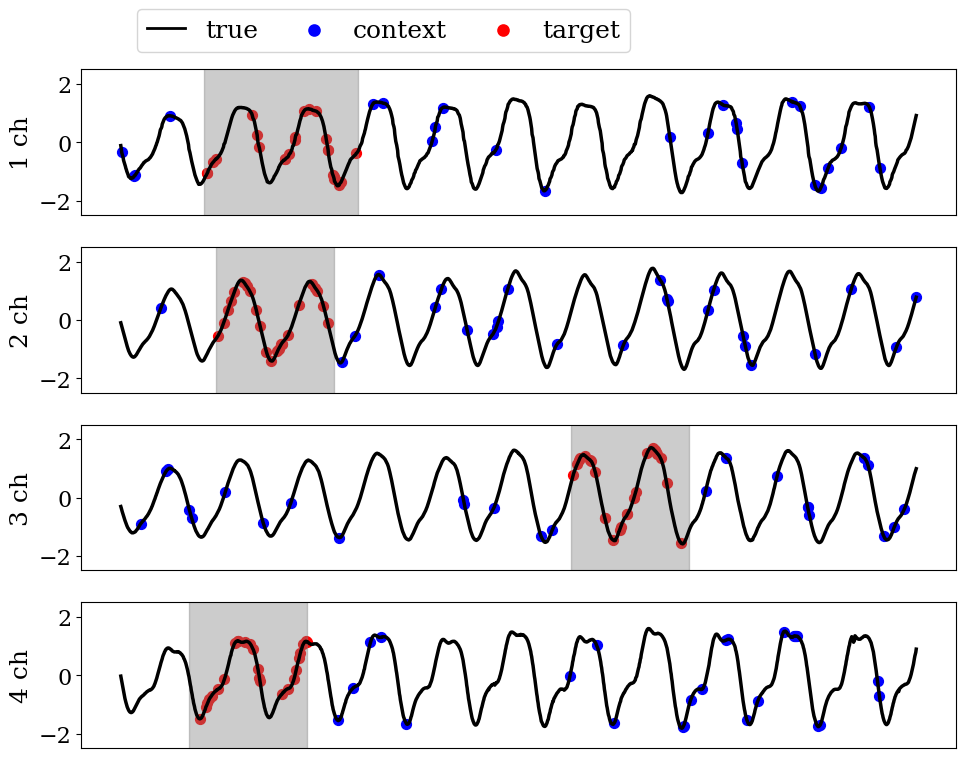

In [16]:
figsiz_ = (10,2.*4)
#bidx=4
wspace_ = 0.5
hspace_ = 0.01
fontsiz_ = 18
ylim_ = [-2.5,2.5]
yticks_ = [-2,0,2]


context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(25,100), intrain = False)
context_x = context_x.squeeze().cpu().data.numpy()
context_y = context_y.squeeze().cpu().data.numpy()
target_x = target_x.squeeze().cpu().data.numpy()
target_y = target_y.squeeze().cpu().data.numpy()




fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

for j in range(num_channels):
    #plt.subplot(nchannels//2,2,j+1)
    plt.subplot(num_channels,1,j+1 )
    
    #imputation region
    #xb = target_x[:,j].min()+0.1,target_x[:,j].max()+0.1
    s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
    xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
    plt.axvspan(xmin = xb[0],xmax = xb[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.4)

    #dataset
    plt.scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=50)
    plt.scatter(target_x[:,j],target_y[:,j],color = 'r',label = 'target',s=50)
    plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=2.5)
    

#     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
#     plt.fill_between(target_x[:,j],
#                      y_mean[:,j] + 2 * y_std[:,j],
#                      y_mean[:,j] - 2 * y_std[:,j],
#                      color='tab:blue', alpha=0.4)

#     if len(y_mean.shape)==2:
#         plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
#         plt.fill_between(target_x[:,j],
#                          y_mean[:,j] + 2 * y_std[:,j],
#                          y_mean[:,j] - 2 * y_std[:,j],
#                          color='tab:blue', alpha=0.4)

        
#     if len(y_mean.shape)==3:
#         for kk in range(2):
#             plt.plot(target_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0,label='model')
#             plt.fill_between(target_x[:,j],
#                              y_mean[kk,:,j] + 2 * y_std[kk,:,j],
#                              y_mean[kk,:,j] - 2 * y_std[kk,:,j],
#                              color='tab:blue', alpha=0.4)
        

    if j == num_channels:
        plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
    else:
        plt.xticks([])

    plt.ylim(ylim_)
    plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    #plt.xlim(xlim_)
    plt.yticks(yticks_,fontsize=fontsiz_-2)

    if j == 0:
        leg = plt.legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=4,handlelength= 1.5, columnspacing =1.5)
        #leg= plt.legend(bbox_to_anchor=(.52,1.37),fontsize = fontsiz-1, ncol = 6 ,handlelength= 1.5, columnspacing =1.5,) 

        for ii in leg.legendHandles:
            ii.set_linewidth(2)      


fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [17]:
# ntask=128
# nbatch=4
best_loss = -np.inf
for i in range(nepochs + 1):   
    avg_loss,loss_list = train_epochs(dataset_dict,time_dict_index,model,opt,lossfun,
                                      ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget)


    #ncontext,ntarget = np.random.randint(10,50,2)        
    ncontext,ntarget = 20,50        
    #val_loss,_ = validate_epochs(gen_cls,model,ntask=16,nbatch=16,ncontext=ncontext,ntarget=50,intrain=True)
    val_loss,_ = validate_epochs(dataset_dict,time_dict_index,model,lossfun,
                                 ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget)


    if best_loss < val_loss:
        
        best_loss = val_loss        
        saved_dict = {'epoch': i + 1,
                     'best_acc_top1': best_loss,                         
                     'state_dict': model.state_dict(),
                     'optimizer': opt.state_dict()}
        torch.save(saved_dict,saved_modelparam_path)
        #print('epochs [{}/{}] | param_saved at {}'.format(i,nepochs,saved_modelparam_path ))

    if i%100 ==0:
        print('epochs [{}/{}] | train loss {:.3f}, val loss {:.3f} \t\t param_saved at {}'.format(i,nepochs,avg_loss,val_loss,saved_modelparam_path ) )       
        #print(loss_list)    
    torch.cuda.empty_cache()

print('done')


/home/yohan/Myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epochs [0/3000] | train loss 350.040, val loss -150.800 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [100/3000] | train loss 223.890, val loss -112.200 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [200/3000] | train loss 170.830, val loss -105.240 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [300/3000] | train loss 138.070, val loss -69.360 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [400/3000] | train loss 95.450, val loss -59.720 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [500/3000] | train loss 106.420, val loss -53.890 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [600/3000] | train loss 74.290, val loss -53.480 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [700/3000] | train loss 71.360, val loss -44.130 		 param_saved at ./param_bramblemet/gpdep_shallow.pth
epochs [800/3000] | train loss 71.300, val loss -43.960 		 param_saved at ./param_bramblemet/gpdep_shallow

RuntimeError: torch.linalg.cholesky: (Batch element 5): The factorization could not be completed because the input is not positive-definite (the leading minor of order 20 is not positive-definite).

## evaluate metric

In [69]:
path1 = saved_modelparam_path 
#model,_ = build_model(model_type=model_type)
model,_,lossfun = get_model(modelname=modelname,cnntype=cnntype)

load_dict = torch.load(path1)
model.load_state_dict(load_dict['state_dict'])   


<All keys matched successfully>

In [70]:
#ntask = 256
ntask,nbatch,ncontext,ntarget = 256,4,20,100
#val_loss_m,val_loss_s = validate_epochs(dataset_dict,time_dict_index,model,ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget, intrain=False)
val_loss_m,val_loss_s = validate_epochs(dataset_dict,time_dict_index,model,lossfun,ntask=ntask,nbatch=nbatch,ncontext=ncontext,ntarget=ntarget , intrain=False)

val_loss_m,val_loss_s

/home/yohan/Myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(-39.14, 0.44)

In [71]:
#Model averages a log likelihood of -47.28 on unseen tasks.
saved_model_path = './fig/exp2_bram/'
datatype = 'bram'

## prediction

In [72]:
#----------------------------------
# small datset
#----------------------------------
context_x,context_y,target_x,target_y = prepare_batch(dataset_dict, time_dict_index , nbatch = 1,batch_npoints=(25,100), intrain = False)
if model.modelname in proposed_model_list and len(context_x.size()) == 3:        
    context_x,target_x=context_x.unsqueeze(dim=-2),target_x.unsqueeze(dim=-2)        

model.eval()
y_mean, y_std = model(context_x.cuda(),context_y.cuda(),target_x.cuda())

#y_mean, y_std = predict_cross(context_x,context_y,target_x,target_y)
y_mean = y_mean.squeeze().cpu().data.numpy()
y_std = y_std.squeeze().cpu().data.numpy()



context_x = context_x.squeeze().cpu().data.numpy()
context_y = context_y.squeeze().cpu().data.numpy()
target_x = target_x.squeeze().cpu().data.numpy()
target_y = target_y.squeeze().cpu().data.numpy()







/home/yohan/Myenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [73]:
figsiz_ = (10,2.*4)
#bidx=4
wspace_ = 0.5
hspace_ = 0.01
fontsiz_ = 18
ylim_ = [-2.5,2.5]
yticks_ = [-2,0,2]

## figures

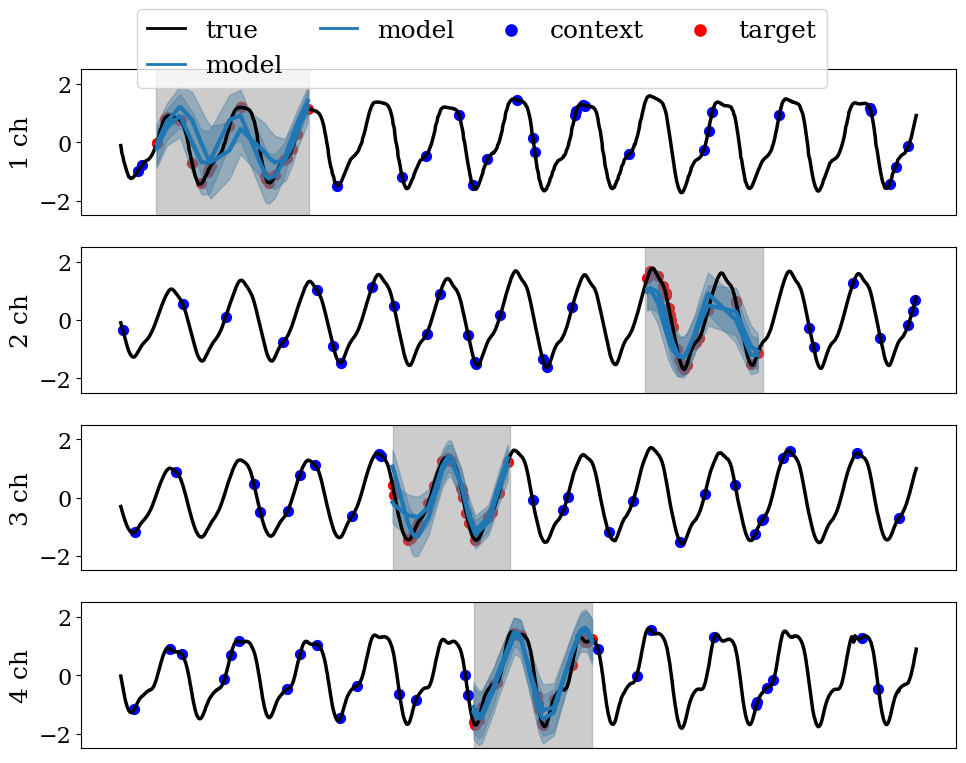

In [74]:
fig = plt.figure(figsize=figsiz_)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

for j in range(num_channels):
    #plt.subplot(nchannels//2,2,j+1)
    plt.subplot(num_channels,1,j+1 )
    
    #imputation region
    #xb = target_x[:,j].min()+0.1,target_x[:,j].max()+0.1
    s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
    xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
    plt.axvspan(xmin = xb[0],xmax = xb[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.4)

    #dataset
    plt.scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=50)
    plt.scatter(target_x[:,j],target_y[:,j],color = 'r',label = 'target',s=50)
    plt.plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=2.5)
    

#     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
#     plt.fill_between(target_x[:,j],
#                      y_mean[:,j] + 2 * y_std[:,j],
#                      y_mean[:,j] - 2 * y_std[:,j],
#                      color='tab:blue', alpha=0.4)

    if len(y_mean.shape)==2:
        plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
        plt.fill_between(target_x[:,j],
                         y_mean[:,j] + 2 * y_std[:,j],
                         y_mean[:,j] - 2 * y_std[:,j],
                         color='tab:blue', alpha=0.4)

        
    if len(y_mean.shape)==3:
        for kk in range(2):
            plt.plot(target_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0,label='model')
            plt.fill_between(target_x[:,j],
                             y_mean[kk,:,j] + 2 * y_std[kk,:,j],
                             y_mean[kk,:,j] - 2 * y_std[kk,:,j],
                             color='tab:blue', alpha=0.4)
        

    if j == num_channels:
        plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
    else:
        plt.xticks([])

    plt.ylim(ylim_)
    plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
    #plt.xlim(xlim_)
    plt.yticks(yticks_,fontsize=fontsiz_-2)

    if j == 0:
        leg = plt.legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=4,handlelength= 1.5, columnspacing =1.5)
        #leg= plt.legend(bbox_to_anchor=(.52,1.37),fontsize = fontsiz-1, ncol = 6 ,handlelength= 1.5, columnspacing =1.5,) 

        for ii in leg.legendHandles:
            ii.set_linewidth(2)      


fig.tight_layout()    
#plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
plt.show()
#'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [49]:




# # fig = plt.figure(figsize=figsiz_)
# # plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= wspace_, hspace= hspace_)

# fig, axs = plt.subplots(nrows=2,ncols=2, sharex=True, sharey=True)
# plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9, wspace=wspace_,hspace=hspace_)

# #for j in range(num_channels):
#     #plt.subplot(nchannels//2,2,j+1)
#     #plt.subplot(num_channels,1,j+1)
# j=0
# s_idx,e_idx = time_dict_index[j]['target_idx'][0],time_dict_index[j]['target_idx'][-1]
# xb = dataset_dict[j]['x'][s_idx], dataset_dict[j]['x'][e_idx]
# axs[0,0].axvspan(xmin = xb[0],xmax = xb[1], ymin = ylim_[0], ymax = ylim_[1],color='gray', alpha=0.4)

# #dataset
# axs[0,0].scatter(context_x[:,j],context_y[:,j],color = 'b',label = 'context',s=50)
# axs[0,0].scatter(target_x[:,j],target_y[:,j],color = 'r',label = 'target',s=50)
# axs[0,0].plot(dataset_dict[j]['x'],dataset_dict[j]['y'],'k',label='true',linewidth=2.5)
# axs[0,0].set(ylim=ylim_)
# #ax1.set_yticks(fontsize=fontsiz_-2)        
# leg0 = axs[0,0].legend(loc = 'upper left',bbox_to_anchor=(.05,1.50),fontsize=fontsiz_,ncol=4,handlelength= 1.5, columnspacing =1.5)
    

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
# #     plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
# #     plt.fill_between(target_x[:,j],
# #                      y_mean[:,j] + 2 * y_std[:,j],
# #                      y_mean[:,j] - 2 * y_std[:,j],
# #                      color='tab:blue', alpha=0.4)

# #     if len(y_mean.shape)==2:
# #         plt.plot(target_x[:,j],y_mean[:,j],color='tab:blue',linewidth=3.0,label='model')
# #         plt.fill_between(target_x[:,j],
# #                          y_mean[:,j] + 2 * y_std[:,j],
# #                          y_mean[:,j] - 2 * y_std[:,j],
# #                          color='tab:blue', alpha=0.4)

        
# #     if len(y_mean.shape)==3:
# #         for kk in range(2):
# #             plt.plot(target_x[:,j],y_mean[kk,:,j],color='tab:blue',linewidth=3.0,label='model')
# #             plt.fill_between(target_x[:,j],
# #                              y_mean[kk,:,j] + 2 * y_std[kk,:,j],
# #                              y_mean[kk,:,j] - 2 * y_std[kk,:,j],
# #                              color='tab:blue', alpha=0.4)
        

# #     if j == num_channels:
# #         plt.xticks(np.linspace(0,3.,6),np.linspace(0,3.,6))
# #     else:
# #         plt.xticks([])

#     #plt.ylim(ylim_)

#     #plt.ylabel('{} ch'.format(j+1),fontsize=fontsiz_)
#     #plt.xlim(xlim_)
#     #plt.yticks(fontsize=fontsiz_-2)



# fig.tight_layout()    
# #plt.savefig(saved_model_path + datatype + '_imputation'+'_convcnp'  + '.pdf' , format='pdf', dpi=1000, bbox_inches='tight')
# plt.show()
# #'./'+datatype + '_imputation'+'convcnp'  + '.pdf'


In [ ]:

xgrid = convcnp.compute_xgrid(xc.squeeze(),yc,xt.squeeze())
_,nh1,h1,h0 = convcnp.encoder(xc.squeeze(),yc,xgrid.squeeze())


fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, sharey=True)
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9,hspace=0.00)
# ax1.plot(xc[0,:,0,0].cpu().data.numpy(),yc[0,:,0].cpu().data.numpy(),color_list[0]+'o-',markersize=10,label='ch 1')
# ax2.plot(xc[0,:,0,1].cpu().data.numpy(),yc[0,:,1].cpu().data.numpy(),color_list[1]+'o-',markersize=10,label='ch 2')

ax1.scatter(xc[0,:,0,0].cpu().data.numpy(),yc[0,:,0].cpu().data.numpy(),color=color_list[0],marker='o',s=150)
ax2.scatter(xc[0,:,0,1].cpu().data.numpy(),yc[0,:,1].cpu().data.numpy(),color=color_list[1],marker='o',s=150)
ax1.plot(xf[0,:,0,0].cpu().data.numpy(),yf[0,:,0].cpu().data.numpy(),color_list[0]+'-',markersize=10,label='ch 1',alpha=0.5)
ax2.plot(xf[0,:,0,1].cpu().data.numpy(),yf[0,:,1].cpu().data.numpy(),color_list[1]+'-',markersize=10,label='ch 2',alpha=0.5)

#for j in range(numsamples):
    #ax1.plot(xa_samples[0,:,0].cpu().data.numpy(),posterior_samples[0,j,:,0].cpu().data.numpy(),'k-'+'s',alpha=0.8,markersize=2)      
    #ax2.plot(xa_samples[0,:,0].cpu().data.numpy(),posterior_samples[0,j,:,1].cpu().data.numpy(),'k-'+'s',alpha=0.8,markersize=2)      
ax1.plot(xgrid[0,:,0].cpu().data.numpy(),nh1[0,:,0].cpu().data.numpy(),'k-',alpha=0.8,linewidth=2)      
ax2.plot(xgrid[0,:,1].cpu().data.numpy(),nh1[0,:,1].cpu().data.numpy(),'k-',alpha=0.8,linewidth=2)      

    
ax1.set(xlim=xlim_,ylim=ylim_)
ax2.set(xlim=xlim_,ylim=ylim_)
ax1.set_xticks(xtick_)
ax2.set_xticks(xtick_)
ax1.set_yticks(ytick_)
ax2.set_yticks(ytick_)

leg_pos = 'lower right'
leg1= ax1.legend(loc=leg_pos ,fontsize=fontsiz,handlelength=.75,ncol=1)
leg2= ax2.legend(loc=leg_pos ,fontsize=fontsiz,handlelength=.75,ncol=1)

for line in leg1.get_lines():
    line.set_linewidth(5) 
    #line.set_markersize(4)
for line in leg2.get_lines():
    line.set_linewidth(5) 
    #line.set_markersize(4)     

    
# plt.xlim(xlim_)
# plt.ylim(ylim_)

savefigname = savepath + 'fig_base_nsamples{}_initl{}'.format(1,init_lscale)
#plt.savefig(savefigname + fig_pdf, dpi=1000,bbox_inches='tight')
savefigname














10

'[0.  0.6 1.2 1.8 2.4 3. ]'